**LIBRARIES AND SETTINGS (PART 1)**

In [1]:
# Libraries
import os
import re
import time
import requests
import json
import fnmatch
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Get Current Working Directory
print(os.getcwd())

/workspaces/data_analytics_project


---
---

**DATA IMPORT / ENRICH**

In [2]:
# READ CSV-FILES
df_imdb = pd.read_csv('IMDB.csv', sep=';', encoding='utf-8')
df_financial = pd.read_csv('BoxOffice.csv', sep=';', encoding='utf-8')

# CLEAN DATA
df_imdb['title'] = df_imdb['title'].str.strip().str.lower()
df_financial['title'] = df_financial['title'].str.strip().str.lower()

# MERGE DATA
df = pd.merge(df_imdb, df_financial, on='title')

# PRINT DATA
print("\nMERGED DATA:")
print(df.head())

# SAVE DATA
df.to_csv('IMDB_Merged_Movies.csv', sep=';', index=False, encoding='utf-8')



MERGED DATA:
                                           title  \
0                                  the godfather   
1                                the dark knight   
2                               schindler's list   
3  the lord of the rings: the return of the king   
4                                   pulp fiction   

                              genres  runtime_(mins) age_rating  \
0                       Crime, Drama             175         16   
1     Action, Crime, Drama, Thriller             152         16   
2          Biography, Drama, History             195         12   
3  Action, Adventure, Drama, Fantasy             201         12   
4                       Crime, Drama             154         16   

               director movie_rating  votes_count worldwide_lifetime_gross  \
0  Francis Ford Coppola          9,2      2070969             $250,342,198   
1     Christopher Nolan          9,0      2950798           $1,009,053,678   
2      Steven Spielberg          9,0

**COUNT / IDENTIFY DUPLICATED VALUES (IF ANY)**

In [3]:
# COUNT DUPLICATED VALUES
print(df.duplicated().sum())

# IDENTIFY ROWS WITH DUPLICATED VALUES
df[df[['title','genres','runtime_(mins)','age_rating','director','movie_rating','votes_count','worldwide_lifetime_gross','domestic_lifetime_gross','foreign_lifetime_gross','release_year']].duplicated()]

0


,title,genres,runtime_(mins),age_rating,director,movie_rating,votes_count,worldwide_lifetime_gross,domestic_lifetime_gross,foreign_lifetime_gross,release_year


**COUNT / IDENTIFY MISSING VALUES (IF ANY)**

In [4]:
# COUNT MISSING VALUES
print(pd.isna(df).sum())

# IDENTIFY ROWS WITH MISSING VALUES
df[df.isna().any(axis=1)].head()

title                       0
genres                      0
runtime_(mins)              0
age_rating                  0
director                    0
movie_rating                0
votes_count                 0
worldwide_lifetime_gross    0
domestic_lifetime_gross     0
foreign_lifetime_gross      0
release_year                4
dtype: int64


,title,genres,runtime_(mins),age_rating,director,movie_rating,votes_count,worldwide_lifetime_gross,domestic_lifetime_gross,foreign_lifetime_gross,release_year
0,the godfather,"Crime, Drama",175,16,Francis Ford Coppola,"9,2",2070969,"$250,342,198","$136,381,073",45.5%,NaN
45,gone with the wind,"Drama, Romance, War",238,12,Victor Fleming,"8,2",340258,"$402,382,193","$200,882,193",50.1%,NaN
69,the exorcist,Horror,122,16,William Friedkin,"8,1",468436,"$430,872,776","$233,005,644",45.9%,NaN
74,jaws,"Adventure, Drama, Thriller",124,16,Steven Spielberg,"8,1",680207,"$477,220,580","$266,567,580",44.1%,NaN


**DROP ROWS WITH MISSING VALUES**

In [5]:
# DROP MISSING VALUES
print(df.shape)
df = df.dropna()

# DROP DUPLICATED VALUES
print(df.shape)

(84, 11)
(80, 11)


**COUNT / DATA TYPE**

In [6]:
# REMOVE SPECIAL CHARACTERS
df['worldwide_lifetime_gross'] = df['worldwide_lifetime_gross'].replace({'\$': '', ',': ''}, regex=True).astype('int64')
df['domestic_lifetime_gross'] = df['domestic_lifetime_gross'].replace({'\$': '', ',': ''}, regex=True).astype('int64')
df['foreign_lifetime_gross'] = df['foreign_lifetime_gross'].replace({'%': '', ',': ''}, regex=True).astype('float64')/100
df['movie_rating'] = df['movie_rating'].str.replace(',', '.').astype('float64')

# CHANGE DATA TYPES
df['age_rating'] = df['age_rating'].astype('int64')
df['release_year'] = df['release_year'].astype('int64')

# DIMENSION (ROWS, COLUMNS)
print('Dimension:', df.shape)
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

# GET DATA TYPES
df.dtypes

Dimension: (80, 11)
Number of rows: 80
Number of columns: 11


title                        object
genres                       object
runtime_(mins)                int64
age_rating                    int64
director                     object
movie_rating                float64
votes_count                   int64
worldwide_lifetime_gross      int64
domestic_lifetime_gross       int64
foreign_lifetime_gross      float64
release_year                  int64
dtype: object

In [7]:
print (df.head())

                                               title  \
1                                    the dark knight   
2                                   schindler's list   
3      the lord of the rings: the return of the king   
4                                       pulp fiction   
5  the lord of the rings: the fellowship of the ring   

                              genres  runtime_(mins)  age_rating  \
1     Action, Crime, Drama, Thriller             152          16   
2          Biography, Drama, History             195          12   
3  Action, Adventure, Drama, Fantasy             201          12   
4                       Crime, Drama             154          16   
5  Action, Adventure, Drama, Fantasy             178          12   

            director  movie_rating  votes_count  worldwide_lifetime_gross  \
1  Christopher Nolan           9.0      2950798                1009053678   
2   Steven Spielberg           9.0      1488804                 322161245   
3      Peter Jackson   

---
---

## Regression Model

### Print columns

In [8]:
# Print all colums in the dataframe
print(df.columns)

Index(['title', 'genres', 'runtime_(mins)', 'age_rating', 'director',
       'movie_rating', 'votes_count', 'worldwide_lifetime_gross',
       'domestic_lifetime_gross', 'foreign_lifetime_gross', 'release_year'],
      dtype='object')


### Train and test samples, train 80% test 20%

This model aims to predict the worldwide lifetime gross of a movie based on its domestic lifetime gross

In [9]:
# Create train and test samples for runtime
X_train, X_test, y_train, y_test = train_test_split(df['domestic_lifetime_gross'], 
                                                    df['worldwide_lifetime_gross'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
77    172825435
63    333718600
57    226277068
41    206863479
10    335477657
Name: domestic_lifetime_gross, dtype: int64 

y_train:
77     354825435
63     773350376
57     619180476
41     375404836
10    1078958629
Name: worldwide_lifetime_gross, dtype: int64


### Fit the simple linear regression model

In [10]:
# Fit the regression model for release year
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            -59518290.67
Slope of regression line (beta):          2.781
p-value:                                  0.0000
R-squared (coefficient of determination): 0.9101


### Plot regression line

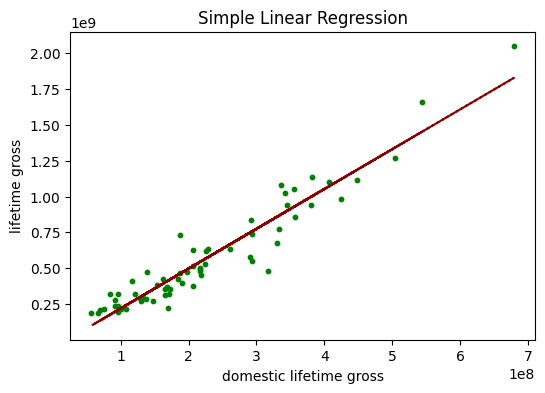

In [11]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('domestic lifetime gross')
plt.ylabel('lifetime gross')

plt.show()

### Check model residuals

In [12]:
# Calculate residuals
residuals = y_train - mymodel

# Check the first residual value
print(f'1st Predicted gross in dataset: {mymodel[0]:.2f}')
print(f'1st Observed gross in dataset: {y_train.iloc[0]:.2f}')  # Use .iloc if y_train is a pandas Series
print(f'1st Residual gross in dataset: {residuals[0]:.2f}')

1st Predicted gross in dataset: 421031851.97
1st Observed gross in dataset: 354825435.00
1st Residual gross in dataset: nan


### Plot histogram of residuals

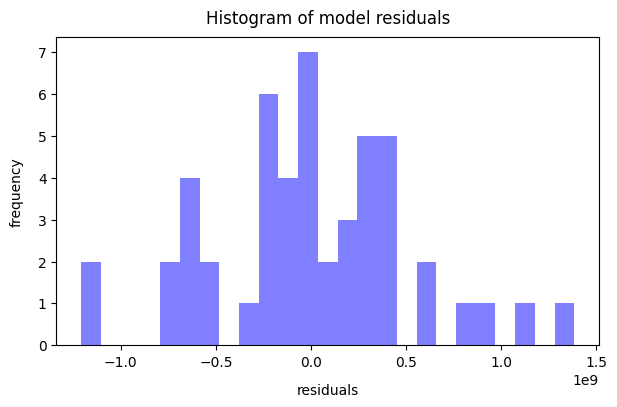

In [13]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

### Compare the observed votes with the predicted votes

In [14]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed gross: {y_test.iloc[i]:.1f}, Predicted gross: {predicted.iloc[i]:.1f}')

Observed gross: 356296601.0, Predicted gross: 302222098.8
Observed gross: 1009053678.0, Predicted gross: 1428041197.8
Observed gross: 2799439100.0, Predicted gross: 2327232638.6
Observed gross: 394436586.0, Predicted gross: 561172361.1
Observed gross: 384577472.0, Predicted gross: 535735294.0
Observed gross: 814641172.0, Predicted gross: 525676766.0
Observed gross: 467840449.0, Predicted gross: 418950589.2
Observed gross: 1520538536.0, Predicted gross: 1673760914.3
Observed gross: 888159923.0, Predicted gross: 828512441.8
Observed gross: 775398507.0, Predicted gross: 1222312119.9


## Multiple linear regression

### Create train and test samples (train = 80%, test = 20% of the data)

In [15]:
# Create train and test samples (we name it X2_ and y_2 because we already used X_ and y_ above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[['votes_count',
                                                            'domestic_lifetime_gross']], 
                                                        df['worldwide_lifetime_gross'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
    votes_count  domestic_lifetime_gross
77       556149                172825435
63      1297306                333718600
57       869288                226277068
41      1615263                206863479
10      1563871                335477657 

y2_train:
77     354825435
63     773350376
57     619180476
41     375404836
10    1078958629
Name: worldwide_lifetime_gross, dtype: int64


### fit the regression model

In [16]:
# Add constant to the model
X2_train_const = sm.add_constant(X2_train)

# Create the multiple regression model
olsmod = sm.OLS(y2_train, X2_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                               OLS Regression Results                               
Dep. Variable:     worldwide_lifetime_gross   R-squared:                       0.911
Model:                                  OLS   Adj. R-squared:                  0.908
Method:                       Least Squares   F-statistic:                     311.6
Date:                      Tue, 14 Jan 2025   Prob (F-statistic):           9.57e-33
Time:                              09:28:02   Log-Likelihood:                -1275.8
No. Observations:                        64   AIC:                             2558.
Df Residuals:                            61   BIC:                             2564.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

### Plot histogram of residuals

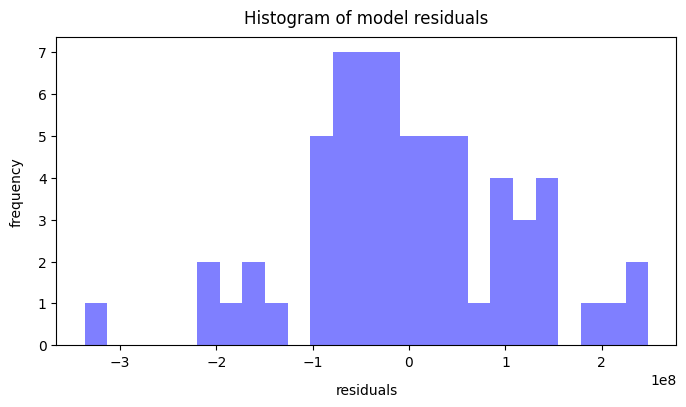

In [ ]:
# Plot histogram of residuals
fig = plt.figure( figsize=(8,4))
n, bins, patches = plt.hist(x=olsres.resid, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

plt.show()

### Compare the observed ratings with the predicted ratings

In [18]:
# Add constant to X2_test
X2_test_const = sm.add_constant(X2_test)
predicted_new = olsres.predict(X2_test_const)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed gross: {y_test.iloc[i]:.1f}, Predicted gross: {predicted_new.iloc[i]:.1f}')

Observed gross: 356296601.0, Predicted gross: 303293459.5
Observed gross: 1009053678.0, Predicted gross: 1457457100.0
Observed gross: 2799439100.0, Predicted gross: 2322041086.0
Observed gross: 394436586.0, Predicted gross: 561577375.3
Observed gross: 384577472.0, Predicted gross: 539962824.6
Observed gross: 814641172.0, Predicted gross: 511698410.1
Observed gross: 467840449.0, Predicted gross: 437804588.7
Observed gross: 1520538536.0, Predicted gross: 1674946715.3
Observed gross: 888159923.0, Predicted gross: 844509006.5
Observed gross: 775398507.0, Predicted gross: 1225654697.1


---
---

**LIBRARIES AND SETTINGS (PART 2)**

In [19]:
# Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Correlation Analysis

In [20]:
# Perform Pearson correlation analysis
res = stats.pearsonr(df['movie_rating'], df['worldwide_lifetime_gross'])
print(f'Pearsons correlation coefficient (r): {res[0]:4f}')
print(f'p-value: {res[1]:.4f}')

Pearsons correlation coefficient (r): 0.167918
p-value: 0.1365


### Interpretation of the correlation coefficient
Because the p-value (0.1365) is greater than 0.05 we cannot reject the null hypothesis. That means there is no statistically significant (5% significance-level) correlation between the variables 'movie_rating' and 'worldwide_lifetime_gross'

## k-means clustering

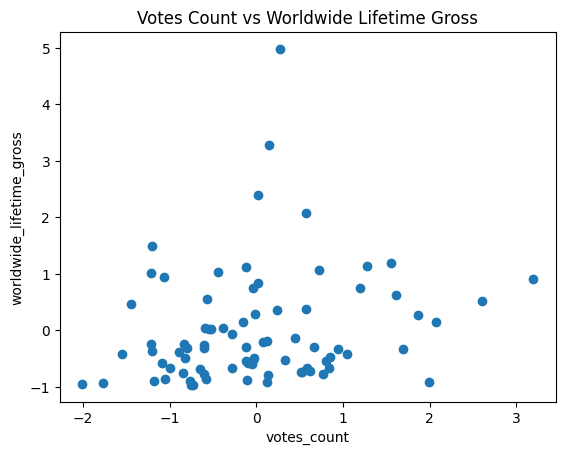

In [21]:
# Create df with two columns
xData = 'votes_count'
yData = 'worldwide_lifetime_gross'
XY_df = pd.DataFrame({xData: df[xData], yData: df[yData]})

# Normalize the data
XY_df = StandardScaler().fit_transform(XY_df)

# Plot the data
plt.scatter(XY_df[:, 0], XY_df[:, 1])
plt.xlabel(xData)
plt.ylabel(yData)
plt.title('Votes Count vs Worldwide Lifetime Gross')
plt.show()

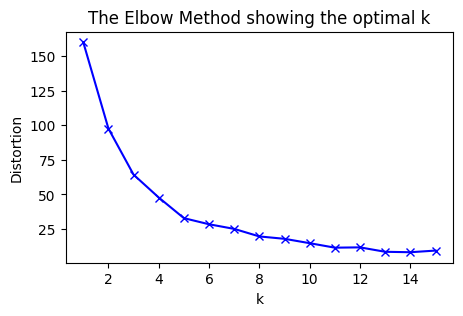

In [22]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,16,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(XY_df)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

### Perform k-means clustering

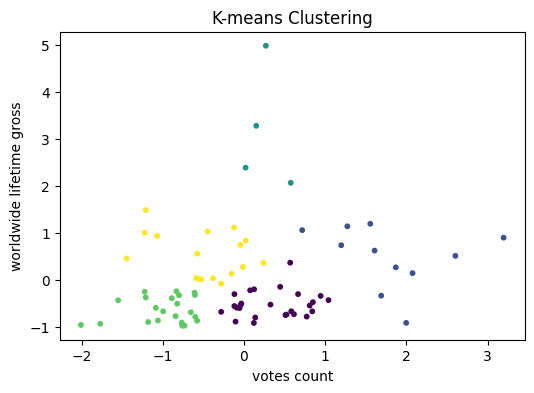

In [23]:
# Number of clusters
k = 5

# Perform k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42).fit(XY_df)

# Predict the values
y2 = kmeans.predict(XY_df)

# Plot the clusters
plt.figure(figsize=(6,4))
plt.scatter(XY_df[:, 0], XY_df[:, 1], c=y2, s=10)
plt.xlabel('votes count')
plt.ylabel('worldwide lifetime gross')
plt.title('K-means Clustering')
plt.show()

### Jupyter notebook --footer info--

In [24]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2025-01-14 09:28:03
Python Version: 3.11.11
-----------------------------------


###